# Declare U-Net CNN

## Load Libraries and Define Constants

In [1]:
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from IPython.display import Image, display
from torchvision import transforms
from PIL import Image as PILImage
import torch.nn.functional as F
import matplotlib.pyplot as plt
import nibabel as nib
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import tempfile
import tarfile
import imageio
import shutil
import torch
import os

In [13]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

in_path = '/Users/Landon/Desktop/thesis/BraTS2021_Training_Data.tar'
data_dir = '/Users/Landon/Desktop/thesis/BraTS2021_Training_Data'

checkpoint_path = './model_weights/deep_last_checkpoint_t1.pth'
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
best_model_path = './model_weights/deep_best_model_t1.pth'
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
validation_loss_path = "./results/deep_validation_loss.txt"
os.makedirs(os.path.dirname(validation_loss_path), exist_ok=True)
training_loss_path = "./results/deep_training_loss.txt"
os.makedirs(os.path.dirname(training_loss_path), exist_ok=True)

EPOCHS = 30
LEARNING_RATE = 0.001
EARLY_STOP = 5
WEIGHT_DECAY = 1e-5

# Parameters
batch_size = 12
val_split = 0.2  # Proportion of the dataset to include in the validation set
test_split = 0.1  # Proportion of the dataset to include in the test set
shuffle_dataset = True  # Shuffle dataset before splitting
random_seed = 42  # Random seed for reproducibility

Using device: cuda


## Visualize Data Sample(s)

In [9]:
def uncompress_tar(tar_file_path, uncompressed_dir):
    if not os.path.isfile(tar_file_path):
        raise FileNotFoundError(f"Tar file not found: {tar_file_path}")

    if not os.path.exists(uncompressed_dir):
        os.makedirs(uncompressed_dir)

    with tarfile.open(tar_file_path, 'r') as tar:
        tar.extractall(path=uncompressed_dir)

    print(f"Uncompressed {tar_file_path} to {uncompressed_dir}")
    
def load_nifti_image(file_path):
    """Load a NIfTI file."""
    img = nib.load(file_path)
    img_data = img.get_fdata()
    return img_data

def create_gif_from_slices(img_data, axis=2, duration=0.1, resize_to=None):
    """
    Create a GIF from slices of a 3D image and display it.
    
    Parameters:
    img_data (numpy.ndarray): 3D image data.
    axis (int): Axis along which to slice the 3D image.
    duration (float): Duration between frames in the GIF.
    """
    # Get the number of slices along the specified axis
    num_slices = img_data.shape[axis]
    
    # Create a temporary directory to store the slice images
    temp_dir = tempfile.mkdtemp()
    
    # Create a list to store the filenames of the slice images
    slice_images = []
    
    for i in range(num_slices):
        plt.figure()
        if axis == 0:
            plt.imshow(img_data[i, :, :], cmap='gray')
        elif axis == 1:
            plt.imshow(img_data[:, i, :], cmap='gray')
        elif axis == 2:
            plt.imshow(img_data[:, :, i], cmap='gray')
        else:
            raise ValueError("Axis must be 0, 1, or 2.")
        plt.axis('off')
        
        # Save the slice image
        slice_filename = os.path.join(temp_dir, f"slice_{i:03d}.png")
        plt.savefig(slice_filename, bbox_inches='tight', pad_inches=0)
        plt.close()
        
        # Append the filename to the list
        slice_images.append(slice_filename)
    
    # Create the GIF
    gif_path = os.path.join(temp_dir, "output.gif")
    with imageio.get_writer(gif_path, mode='I', duration=duration, loop=0) as writer:
        for slice_filename in slice_images:
            image = imageio.v2.imread(slice_filename)
            if resize_to:
                image = PILImage.fromarray(image).resize(resize_to, PILImage.Resampling.LANCZOS)
                image = np.array(image)
            writer.append_data(image)
    
    # Display the GIF
    display(Image(filename=gif_path))
    
    # Clean up temporary slice images
    shutil.rmtree(temp_dir)

In [10]:
uncompress_tar(in_path, data_dir)

C:\Users\Landon\AppData\Local\Temp\ipykernel_11660\2593610066.py:9: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=uncompressed_dir)


Uncompressed /Users/Landon/Desktop/thesis/BraTS2021_Training_Data.tar to /Users/Landon/Desktop/thesis/BraTS2021_Training_Data


(240, 240, 155)


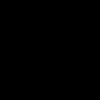

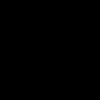

In [11]:
path = 'BraTS2021_Training_Data/BraTS2021_00100/BraTS2021_00100'
suffixes = ['_t1.nii.gz', '_seg.nii.gz']

nifti_t1_path = path + suffixes[0]
img_t1 = load_nifti_image(nifti_t1_path)
print(img_t1.shape)
create_gif_from_slices(img_t1, axis=2, duration=0.1, resize_to=(100, 100))

nifti_seg_path = path + suffixes[1]
img_seg = load_nifti_image(nifti_seg_path)
create_gif_from_slices(img_seg, axis=2, duration=0.1, resize_to=(100, 100))

(240, 240, 155)


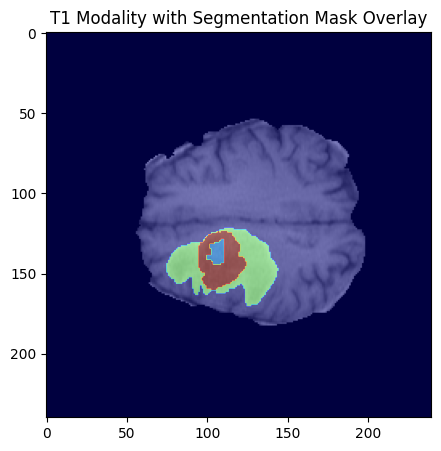

In [12]:
# Visualize one sample - T1ce Modality with overlaid segmentation mask
slice = 100
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
print(img_t1.shape)
ax.imshow(img_t1[:,:,slice], cmap='gray')
ax.imshow(img_seg[:,:,slice], cmap='jet', alpha=0.5)  # alpha controls the transparency

ax.set_title('T1 Modality with Segmentation Mask Overlay')
#ax.axis('off')

plt.show()

## Dataset loading

For now, use T1 data only, but this is completely arbitary

In [3]:
class BRATST1Dataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.samples = [
            sample for sample in os.listdir(data_dir)
            if sample.startswith('BraTS') and 
            os.path.exists(os.path.join(data_dir, sample, f"{sample}_t1.nii.gz")) and 
            os.path.exists(os.path.join(data_dir, sample, f"{sample}_seg.nii.gz"))
        ]
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample_name = self.samples[idx]
        sample_dir = os.path.join(self.data_dir, sample_name)
        
        # Load MRI modalities and segmentation mask
        t1_path = os.path.join(sample_dir, f"{sample_name}_t1.nii.gz")
        seg_path = os.path.join(sample_dir, f"{sample_name}_seg.nii.gz")

        # Load and preprocess the T1 data
        h, w = 128, 128    
        t1_data = nib.load(t1_path).get_fdata()
        t1_data = np.resize(t1_data, (h, w, 155))
        
        # Load and preprocess the segmentation data
        seg_data = nib.load(seg_path).get_fdata()
        seg_data = np.resize(seg_data, (h, w, 155))
        seg_data = np.transpose(seg_data, (2, 0, 1))
        
        # Convert numpy arrays to PyTorch tensors
        x = np.transpose(t1_data, (2, 0, 1))
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(seg_data, dtype=torch.float32)
        
        return x, y


## Use the T1 data only for segmentation

Segmentation specified by associated "\_seg" files

In [14]:
# Load the dataset
dataset = BRATST1Dataset(data_dir)

# Determine the lengths of training, validation, and test sets
dataset_size = len(dataset)
test_size = int(test_split * dataset_size)
val_size = int(val_split * (dataset_size - test_size))
train_size = dataset_size - val_size - test_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(random_seed)
)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_dataset)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Optionally print the sizes of each dataset to verify
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 901
Validation set size: 225
Test set size: 125


Using device: cuda


(-0.5, 127.5, 127.5, -0.5)

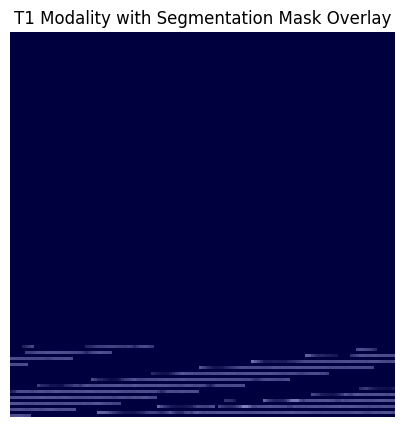

In [15]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load one batch from the validation dataloader
data_iter = iter(test_dataloader)
t1_batch, seg_batch = next(data_iter)

# Select the first sample in the batch
t1_sample = t1_batch[2]  # Shape: (155, H, W)
seg_sample = seg_batch[2]  # Shape: (155, H, W)

# Choose the slice to visualize
slice_idx = 80  # Adjust this to view different slices
t1_slice = t1_sample[slice_idx].cpu().numpy()
seg_slice = seg_sample[slice_idx].cpu().numpy()

# Plot the slice with overlay
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(t1_slice, cmap='gray')
ax.imshow(seg_slice, cmap='jet', alpha=0.5)  # Overlay with segmentation mask

ax.set_title('T1 Modality with Segmentation Mask Overlay')
ax.axis('off')
#plt.show()


## Define 2D Convolutional Neural Network model

In [1]:
class UNet2D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet2D, self).__init__()

        self.dropout = nn.Dropout(0.2)
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        self.bottleneck = self.conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        #print(f"X shape: {x.shape}")
        x = self.dropout(x)
        enc1 = self.encoder1(x)
        #print(f"Enc1 shape: {enc1.shape}")
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        #print(f"Enc2 shape: {enc2.shape}")
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        #print(f"Enc3 shape: {enc3.shape}")
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))
        #print(f"Enc4 shape: {enc4.shape}")

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))
        #print(f"Bottleneck shape: {bottleneck.shape}")

        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        #print(f"Dec4 shape: {dec4.shape}")
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        #print(f"Dec3 shape: {dec3.shape}")
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        #print(f"Dec2 shape: {dec2.shape}")
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        #print(f"Dec1 shape: {dec1.shape}")
        
        output = self.final_conv(dec1)
        #print(f"Output shape: {output.shape}")
        return output

NameError: name 'nn' is not defined

In [17]:
## Model Summary
model = UNet2D(155, 155)
#model = nn.DataParallel(model)
model = model.to(device) # Ensure the model is on GPU

## Training

### Setup

In [18]:
class DiceLoss(nn.Module):
    # Use DiceLoss as metric
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)  # Apply sigmoid to get probabilities
        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = DiceLoss()

# Early stopping parameters
early_stopping_patience = EARLY_STOP
best_val_loss = float('inf')
patience_counter = 0

# Number of epochs
num_epochs = EPOCHS

### Train

In [20]:
# Load checkpoint if it exists
start_epoch = 0
best_val_loss = float('inf')
#checkpoint_path = "home/lmattin1/HonorsThesis/model_weights/best_model_t1.pth"

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    print(f"Resuming training from epoch {start_epoch}")


In [21]:
scaler = GradScaler()
training_losses = []
validation_losses = []
patience_counter = 0

with open(training_loss_path, "a") as f:
    f.write("starting new training\n")
with open(validation_loss_path, "a") as f:
    f.write("starting new training\n")

for epoch in range(start_epoch, num_epochs):
    print('Starting Epoch {}'.format(epoch+1))
    model.train()
    train_loss = 0.0
    train_loader = tqdm(train_dataloader, desc="Training", leave=False)
    batch_increment = 0
    for vimage, mask in train_loader:
        if vimage is None or mask is None:
            continue 
        vimage, mask = vimage.to(device).float(), mask.to(device).float()
        optimizer.zero_grad()
        
        predicted_mask = model(vimage)
        
        loss = loss_fn(predicted_mask, mask)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        """
        if batch_increment == 1: 
                fig, axs = plt.subplots(2, 2, figsize=(15, 5))
                axs[0,0].imshow(vimage[0,50,:,:].cpu().detach(), cmap="gray")
                axs[0,0].set_title('Input Image')
                axs[0,1].imshow(predicted_mask[0,50, :, :].cpu().detach().numpy(), cmap="viridis", alpha=0.5)
                axs[0,1].set_title("Predicted Mask")
                axs[1,0].imshow(mask[0,50,:,:].cpu().detach(), cmap="viridis", alpha=0.5)
                axs[1,0].set_title("Actual Mask")
                axs[1,1].imshow(mask[0,50, :, :].cpu().detach().numpy(), cmap="viridis", alpha=0.5)
                axs[1,1].set_title("Actual Mask")
                plt.show()
                plt.close(fig)
        batch_increment = batch_increment + 1
        """
            
    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    with open(training_loss_path, "a") as f:
        f.write(f"{avg_train_loss}\n")

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        validation_loader = tqdm(val_dataloader, desc="Validation", leave=False)
        #batch_increment = 0
        for vimage, mask in validation_loader:
            vimage, mask = vimage.to(device).float(), mask.to(device).float()
                
            predicted_mask = model(vimage)
            loss = loss_fn(predicted_mask, mask)
            val_loss += loss.item()

            ##PRINTING MASKS
            """
            if batch_increment == 1: 
                fig, axs = plt.subplots(2, 2, figsize=(15, 5))
                axs[0,0].imshow(vimage[0,50,:,:].cpu().detach(), cmap="gray")
                axs[0,0].set_title('Input Image')
                axs[0,1].imshow(predicted_mask[0,50, :, :].cpu().detach().numpy(), cmap="viridis", alpha=0.5)
                axs[0,1].set_title("Predicted Mask")
                axs[1,0].imshow(mask[0,50,:,:].cpu().detach(), cmap="viridis", alpha=0.5)
                axs[1,0].set_title("Actual Mask")
                axs[1,1].imshow(mask[0,50, :, :].cpu().detach().numpy(), cmap="viridis", alpha=0.5)
                axs[1,1].set_title("Actual Mask")
                plt.show()
                plt.close(fig)
            batch_increment = batch_increment + 1
            """

    val_loss /= len(val_dataloader)
    validation_losses.append(val_loss)
    with open(validation_loss_path, "a") as g:
        g.write(f"{val_loss}\n")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {val_loss}")

    # Save the checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'best_val_loss': best_val_loss,
    }
    torch.save(checkpoint, checkpoint_path)

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), best_model_path)
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


C:\Users\Landon\AppData\Local\Temp\ipykernel_5060\1581376396.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Starting Epoch 1


Epoch 1/30, Training Loss: 0.679193241815818, Validation Loss: 0.4611791027219672
Starting Epoch 2


Epoch 2/30, Training Loss: 0.47474265961270584, Validation Loss: 0.4806813503566541
Starting Epoch 3


Epoch 3/30, Training Loss: 0.4751187147278535, Validation Loss: 0.454887308572468
Starting Epoch 4


Epoch 4/30, Training Loss: 0.46467368540010956, Validation Loss: 0.4428074046185142
Starting Epoch 5


Epoch 5/30, Training Loss: 0.4402788077530108, Validation Loss: 0.4363386254561575
Starting Epoch 6


Epoch 6/30, Training Loss: 0.42987123445460673, Validation Loss: 0.40408700704574585
Starting Epoch 7


Epoch 7/30, Training Loss: 0.36243582477695063, Validation Loss: 0.30088769448430913
Starting Epoch 8


Epoch 8/30, Training Loss: 0.24519864116844378, Validation Loss: 0.23754190771203293
Starting Epoch 9


Epoch 9/30, Training Loss: 0.2420100499140589, Validation Loss: 0.21758453155818738
Starting Epoch 10


Epoch 10/30, Training Loss: 0.22701631564843028, Validation Loss: 0.1977964953372353
Starting Epoch 11


Epoch 11/30, Training Loss: 0.20462926359553085, Validation Loss: 0.1915963574459678
Starting Epoch 12


Epoch 12/30, Training Loss: 0.18893683113549886, Validation Loss: 0.17026501580288536
Starting Epoch 13


Epoch 13/30, Training Loss: 0.1764430074315322, Validation Loss: 0.1903795129374454
Starting Epoch 14


Epoch 14/30, Training Loss: 0.18312621665628334, Validation Loss: 0.17417823327215096
Starting Epoch 15


Epoch 15/30, Training Loss: 0.16589129206381345, Validation Loss: 0.14937646138040642
Starting Epoch 16


Epoch 16/30, Training Loss: 0.1617398042427866, Validation Loss: 0.15551672170036718
Starting Epoch 17


Epoch 17/30, Training Loss: 0.15841628689514964, Validation Loss: 0.14427613898327477
Starting Epoch 18


Epoch 18/30, Training Loss: 0.14738138176892934, Validation Loss: 0.1327241627793563
Starting Epoch 19


Epoch 19/30, Training Loss: 0.13894717630587125, Validation Loss: 0.13272285775134438
Starting Epoch 20


Epoch 20/30, Training Loss: 0.14062759358631938, Validation Loss: 0.1265839087335687
Starting Epoch 21


Epoch 21/30, Training Loss: 0.17097495731554532, Validation Loss: 0.15237730741500854
Starting Epoch 22


Epoch 22/30, Training Loss: 0.15030893369724876, Validation Loss: 0.1330120092944095
Starting Epoch 23


Epoch 23/30, Training Loss: 0.13674467096203252, Validation Loss: 0.1265514336134258
Starting Epoch 24


Epoch 24/30, Training Loss: 0.13433077696122622, Validation Loss: 0.127780208462163
Starting Epoch 25


Epoch 25/30, Training Loss: 0.13839274644851685, Validation Loss: 0.127780208462163
Starting Epoch 26


Epoch 26/30, Training Loss: 0.1334156323420374, Validation Loss: 0.1202558341779207
Starting Epoch 27


Epoch 27/30, Training Loss: 0.1395061094509928, Validation Loss: 0.13849590012901708
Starting Epoch 28


Epoch 28/30, Training Loss: 0.14628088866409503, Validation Loss: 0.12581781337135717
Starting Epoch 29


Epoch 29/30, Training Loss: 0.13075564252702812, Validation Loss: 0.12018176128989772
Starting Epoch 30


Epoch 30/30, Training Loss: 0.12865438037797025, Validation Loss: 0.12018176128989772


## Analyze the results - plot and numerical

In [12]:
# Calculate the number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# Assuming 4 bytes per parameter (float32)
model_size_bytes = total_params * 4

# Print the model size in bytes and human-readable format
print(f"Model size: {model_size_bytes} bytes")
print(f"Model size (human-readable): {model_size_bytes / (1024**3):.2f} GB")

Model size: 124517228 bytes
Model size (human-readable): 0.12 GB


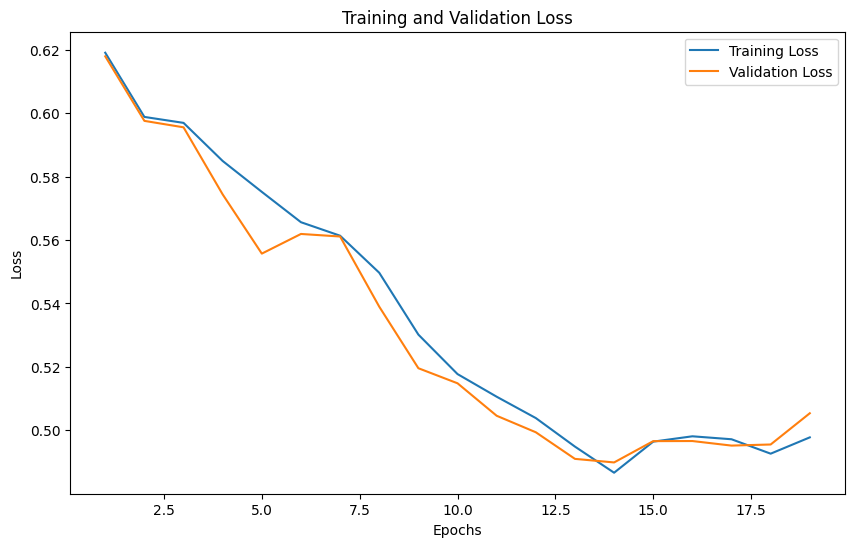

In [35]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epoch + 2), training_losses, label='Training Loss')
plt.plot(range(1, epoch + 2), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
#plt.savefig("/home/lmattin1/HonorsThesis/unet_cnnLoss.png")
plt.show()

In [22]:
def dice_coefficient(predicted, target):
    """
    Compute the Dice Coefficient.
    :param predicted: the logits or the prediction from the model.
    :param target: the target mask.
    :return: the Dice coefficient.
    """
    smooth = 1e-5 
    #added .float() and removed thresholding
    predicted = torch.sigmoid(predicted).float()
    #predicted = (predicted > 0.5).float() 
    
    intersection = (predicted * target.float()).sum()
    dice = (2. * intersection + smooth) / (predicted.sum() + target.sum() + smooth)
    
    return dice

def iou_score(predicted, target):
    """
    Compute the Intersection over Union (IoU) score.
    :param predicted: the logits or the prediction from the model.
    :param target: the target mask.
    :return: the IoU score.
    """
    predicted = torch.sigmoid(predicted)  
    predicted = (predicted > 0.5).float()  
    
    intersection = (predicted * target).sum()
    union = predicted.sum() + target.sum() - intersection
    
    iou = (intersection + 1.0) / (union + 1.0)  
    return iou
    
# Set the model to evaluation mode
model.eval()
dice_scores = []
iou_scores = []

with torch.no_grad():
    for images, true_masks in test_dataloader:
        images = images.to(device).float()  
        true_masks = true_masks.to(device).float() 
        preds = model(images)
        for pred, true_mask in zip(preds, true_masks):
            #pred = torch.sigmoid(pred).float() 
            #pred = (pred > 0.5).float() 

            dice_scores.append(dice_coefficient(pred, true_mask).item())
            iou_scores.append(iou_score(pred, true_mask).item())

print(f"Average Dice Coefficient: {(sum(dice_scores) / len(dice_scores))}")
print(f"Average IoU Score: {sum(iou_scores) / len(iou_scores)}")

Average Dice Coefficient: 0.00709543306060927
Average IoU Score: 0.0036286202391638653


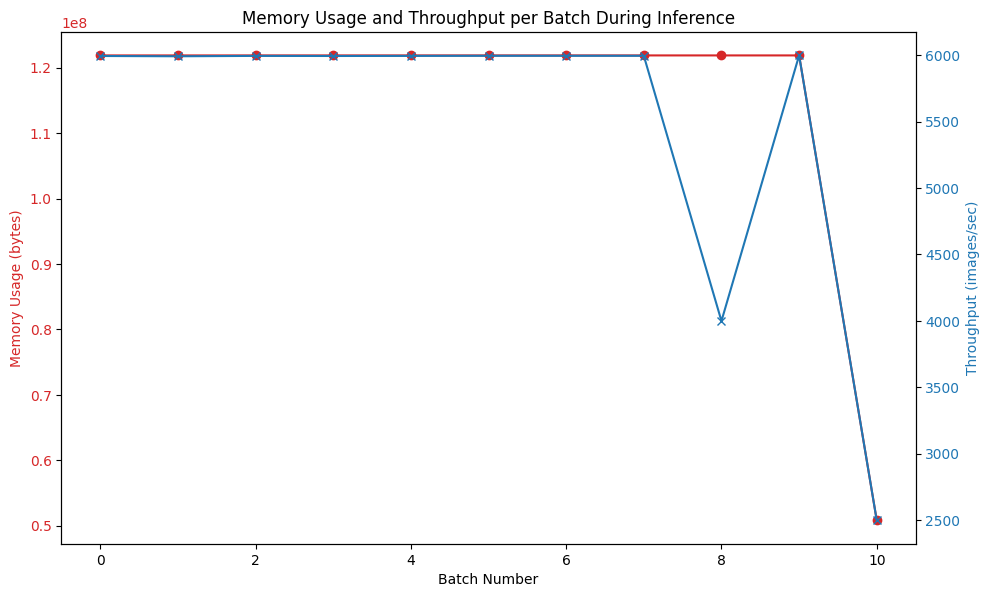

In [24]:
import time

def evaluate_performance(model, data_loader, device):
    model.eval()
    memory_usages = []
    throughputs = []
    batch_sizes = []

    with torch.no_grad():
        for X, _ in data_loader:
            batch_sizes.append(X.size(0))
            
            # Measure memory usage
            initial_memory = torch.cuda.memory_allocated(device)
            X = X.to(device).float()
            
            # Measure throughput
            start_time = time.time()
            model(X)
            end_time = time.time()
            
            current_memory = torch.cuda.memory_allocated(device)
            memory_usage = current_memory - initial_memory
            memory_usages.append(memory_usage)
            
            # Calculate throughput for this batch
            throughput = X.size(0) / (end_time - start_time)
            throughputs.append(throughput)

    return memory_usages, throughputs, batch_sizes

# Evaluate the model
memory_usages, throughputs, batch_sizes = evaluate_performance(model, test_dataloader, device)

with open('deep_np_performance_values.txt', 'w') as f:
    f.write("Batch Number,Memory Usage (bytes),Throughput (images/sec)\n")
    for i in range(len(memory_usages)):
        f.write(f"{i+1},{memory_usages[i]},{throughputs[i]}\n")

# Plotting the results
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Batch Number')
ax1.set_ylabel('Memory Usage (bytes)', color=color)
ax1.plot(memory_usages, color=color, marker='o', label='Memory Usage')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 
color = 'tab:blue'
ax2.set_ylabel('Throughput (images/sec)', color=color)
ax2.plot(throughputs, color=color, marker='x', label='Throughput')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Memory Usage and Throughput per Batch During Inference')
plt.show()